<h3><center>1. Importing Libraries</center></h3>


<div style="font-family:verdana; word-spacing:1.7px;">

In [ ]:
!pip install -q mtcnn

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import matplotlib.pyplot as plt


from mtcnn.mtcnn import MTCNN

from PIL import Image

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.utils.vis_utils import plot_model

<h3><center>2. Exploring the dataset</center></h3>

In [ ]:
PATH = '../input/celeba-dataset/img_align_celeba/img_align_celeba/'

def load_image(filename):
    image = Image.open(filename)
    image = image.convert('RGB')
    image = np.asarray(image)
    
    return image

def load_faces(path, n_faces):
    faces = list()
    for filename in tqdm(os.listdir(path)):
        face = load_image(path+filename)
        faces.append(face)
        if len(faces) >= n_faces:
            break
    
    return np.asarray(faces)

def plot_faces(faces, n):
    plt.figure(figsize=(13,8))
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(faces[i])
    plt.show()

In [ ]:
faces = load_faces(PATH, 25)
plot_faces(faces, 5)

In [ ]:
faces[0].shape

<h3><center>3. Extract Faces using MTCNN</center></h3>

In [ ]:
'''
Below functions take a lot of time to extract faces from 50k images, 
They were ran once and the output of the function was store in file img_align_celeba.npz
The intention behind doing this is to save time running the below functions again in future




def extract_face(model, pixels, required_size=(80, 80)):
    faces = model.detect_faces(pixels)
    
    # skip cases where we could not detect a face
    if len(faces) == 0:
        return None
    x1, y1, width, height = faces[0]['box']
    
    # force detected pixel values to be positive (bug fix) 
    x1, y1 = abs(x1), abs(y1)    
    
    x2, y2 = x1 + width, y1 + height
    
    face_pixels = pixels[y1:y2, x1:x2]
    
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    
    face_array = np.asarray(image)
    
    return face_array
    
    
def load_faces(path, n_faces):
    model = MTCNN()
    faces = list()
    
    for filename in tqdm(os.listdir(path)):
        pixels = load_image(path+filename)
        
        face = extract_face(model, pixels)
        
        if face is None:
            continue
            
        faces.append(face)
        if len(faces) >= n_faces:
            break
    
    return np.asarray(faces)


all_faces = load_faces(PATH, 50000)

'''

In [ ]:
'''
np.savez_compressed('img_align_celeba.npz', all_faces)
'''

In [ ]:
data = np.load('../input/detected-faces-mtcnn/img_align_celeba.npz')

faces = data['arr_0']

print('Loaded: ', faces.shape)

In [ ]:
plot_faces(faces, 5)

<h2><center>Developing GAN for CelebA Data</center></h2>

<h3><center>4. Define Discriminiator</center></h3>

In [ ]:
def define_discriminator(in_shape=(80,80,3)):
    model = Sequential()
    
    #Normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    #Downsample to 40x40
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #Downsample to 20x20
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #Downsample to 10x10
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #Downsample to 5x5
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

model = define_discriminator()

plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

<h3><center>5. Define Generator</center></h3>

<div style="font-family:verdana; word-spacing:1.7px;">
It is recommended to use the hyperbolic tangent activation function as the output from the generator model. As such, it is also recommended that real images used to train the discriminator are scaled so that their pixel values are in the range [-1,1]. This is so that the discriminator will always receive images as input, real and fake, that have pixel values in the same range.
    </div>

In [ ]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 5 * 5 
    
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 5, 128)))
    
    #upsample to 10x10
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #upsample to 20x20
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))  
    
    #upsample to 40x40
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #upsample to 80x80
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    
    return model



latent_dim = 100

model = define_generator(latent_dim)

plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

<h3><center>6. Define GAN (Generator + Discriminator)</center></h3>

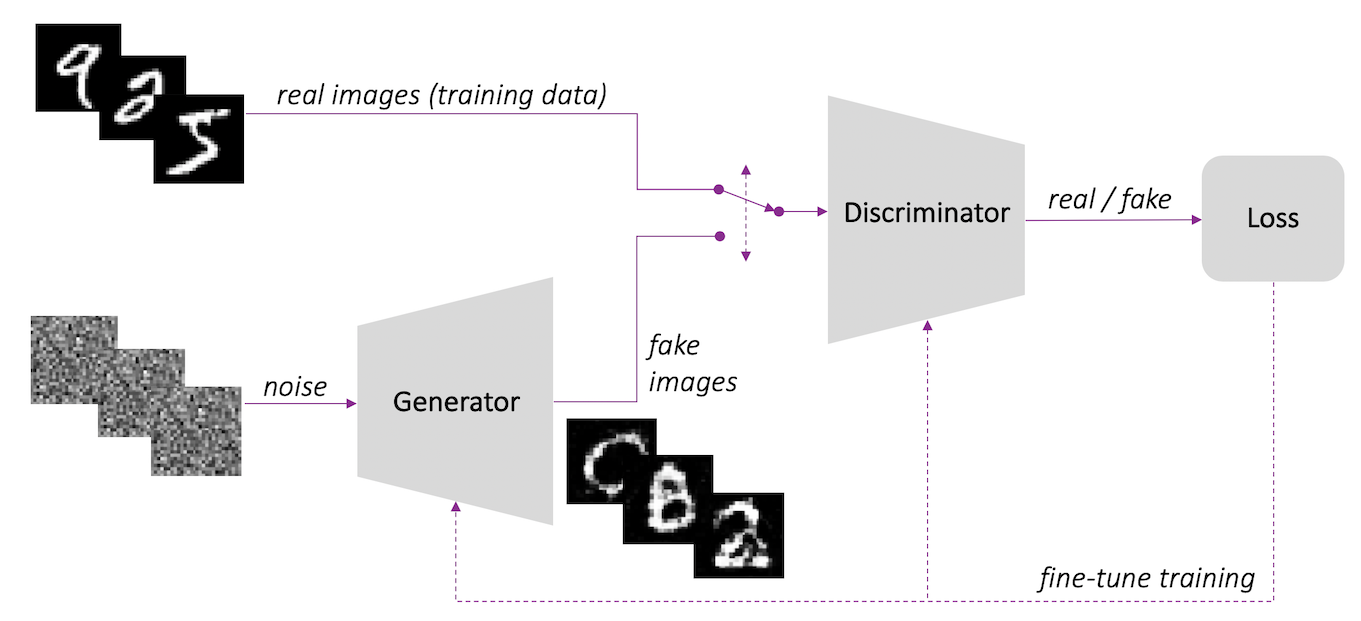

In [ ]:
# define the combined generator and discriminator model, for updating the generator

def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

In [ ]:
latent_dim = 100

discriminator = define_discriminator()

generator = define_generator(latent_dim)

gan_model = define_gan(generator, discriminator)

# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

<h3><center>7. Generating Real Samples</center></h3>

In [ ]:
def load_real_samples():
    trainX = np.load('../input/detected-faces-mtcnn/img_align_celeba.npz')

    X = trainX['arr_0']
    
    X = X.astype('float32')
    
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    
    return X


def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    
    return X, y

<h3><center>8. Create Latent space & Generate Fake Samples from it</center></h3>

<div style="font-family:verdana; word-spacing:1.7px;">
We have to generate new random points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.
    </div>

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input


def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    
    y = np.zeros((n_samples, 1))
    
    return X, y

In [ ]:
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)

X = (X + 1) / 2.0
plt.figure(figsize=(10, 5))
for i in range(n_samples):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(X[i])

plt.show()

<div style="font-family:verdana; word-spacing:1.7px;">
Running the example generates 25 examples of fake  images and visualizes them on a single plot of 5 by 5 images. As the model is not trained, the generated images are completely random pixel values in [-1, 1], rescaled to [0, 1]. As we might expect, the images look like a mess of gray.
    </div>

<h3><center>9. Train GAN Network</center></h3>

<div style="font-family:verdana; word-spacing:1.7px;">
First, the discriminator model is updated for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates. <br><br>The generator is then updated via the combined GAN model. <br><br>Importantly, the class label is set to 1 or real for the fake samples. This has the effect of updating the generator toward getting better at generating real samples on the next batch.</div>

In [ ]:
def save_plot(examples, epoch, n=10):
  # plot images
    plt.figure(figsize=(10,5))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
        # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1) 
    plt.savefig(filename)
    plt.close()

def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
    x_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)

    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    save_plot(x_fake, epoch)
    
    # save model to file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    generator.save(filename)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        g_losses, d_losses = list(), list()
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))

            #Train & Update Discriminator weights
            d_loss, _ = d_model.train_on_batch(X, y)

            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)

            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))

            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            g_losses.append(g_loss)
            d_losses.append(d_loss)

        print('>%d, d=%.3f, g=%.3f' % (i+1, np.mean(d_losses), np.mean(g_losses)))
        
        # evaluate the model every n_eval epochs
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
latent_dim = 100

discriminator = define_discriminator()

generator = define_generator(latent_dim)

gan_model = define_gan(generator, discriminator)

dataset = load_real_samples()

train(generator, discriminator, gan_model, dataset, latent_dim)

<h3>1. After 10 EPOCHS</h3>

In [ ]:
OUTPUT_PATH = '/kaggle/input/output-gan-model/'

plt.figure(figsize=(30,20))
img = plt.imread(OUTPUT_PATH+'generated_plot_e010.png')
_ = plt.axis('off')
_ = plt.imshow(img)

<h3>2. After 50 EPOCHS</h3>

In [ ]:
OUTPUT_PATH = '/kaggle/input/output-gan-model/'

plt.figure(figsize=(30,20))
img = plt.imread(OUTPUT_PATH+'generated_plot_e050.png')
_ = plt.axis('off')
_ = plt.imshow(img)

<h3>3. After 100 EPOCHS</h3>

In [ ]:
OUTPUT_PATH = '/kaggle/input/output-gan-model/'

plt.figure(figsize=(30,20))
img = plt.imread(OUTPUT_PATH+'generated_plot_e100.png')
_ = plt.axis('off')
_ = plt.imshow(img)

<h3><center>10. Explore the Latent Space for Generated Faces</center></h3>

In [ ]:
from keras.models import load_model

def generate_latent_points(latent_dim, n_samples):
    
    x_input = np.random.randn(latent_dim * n_samples)
    
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input
                           
def show_plot(examples, n):
  # plot images
    plt.figure(figsize=(20,10))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    plt.show()

In [ ]:
model = load_model(OUTPUT_PATH+'generator_model_100.h5')

latent_points = generate_latent_points(100, 16) 

X = model.predict(latent_points)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
show_plot(X, 4)

<h3><center>11. Interpolate Between Generated Faces</center></h3>

In [ ]:
np.linspace(0, 1, num=5)

In [ ]:
def interpolate_points(p1, p2, n_steps=10):
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)


def plot_generated(examples, n):
    plt.figure(figsize=(20,5))
    for i in range(n):
    
        plt.subplot(1, n, 1 + i)
    
        plt.axis('off')

        plt.imshow(examples[i])
    plt.show()

In [ ]:
model = load_model(OUTPUT_PATH+'generator_model_100.h5')

latent_points = generate_latent_points(100, 2) 

interpolated = interpolate_points(latent_points[0], latent_points[1])
X = model.predict(interpolated)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plot_generated(X, len(interpolated))

In [ ]:
latent_points = generate_latent_points(100, 2) 

interpolated = interpolate_points(latent_points[0], latent_points[1])
X = model.predict(interpolated)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plot_generated(X, len(interpolated))

In [ ]:
latent_points = generate_latent_points(100, 2) 

interpolated = interpolate_points(latent_points[0], latent_points[1])
X = model.predict(interpolated)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plot_generated(X, len(interpolated))

In [ ]:
latent_points = generate_latent_points(100, 2) 

interpolated = interpolate_points(latent_points[0], latent_points[1])
X = model.predict(interpolated)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plot_generated(X, len(interpolated))

<div style="font-family:verdana; word-spacing:1.7px;">
We have performed a linear interpolation which assumes that the latent space is a uniformly distributed hypercube. Technically, our chosen latent space is a 100-dimension hypersphere or multimodal Gaussian distribution. There is a mathematical function called the spherical linear interpolation function, or Slerp, that should be used when interpolating this space to ensure the curvature of the space is taken into account.
    </div>

In [ ]:
from numpy import vstack
from numpy.random import randn
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm



# spherical linear interpolation (slerp)
def slerp(val, low, high):
    omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
    so = sin(omega)
    if so == 0:
        # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

def interpolate_points(p1, p2, n_steps=10):
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = list()
    for ratio in ratios:
        v = slerp(ratio, p1, p2)
        vectors.append(v)
    return np.asarray(vectors)

In [ ]:
latent_points = generate_latent_points(100, 2) 

interpolated = interpolate_points(latent_points[0], latent_points[1])
X = model.predict(interpolated)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plot_generated(X, len(interpolated))

In [ ]:
latent_points = generate_latent_points(100, 2) 

interpolated = interpolate_points(latent_points[0], latent_points[1])
X = model.predict(interpolated)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plot_generated(X, len(interpolated))

<h3><center>12. Vector Arithmetic in Latent Space</center></h3>

        smiling woman − neutral woman + neutral man = smiling man

In [ ]:
POINTS_PATH = '/kaggle/working/'
x = np.load(POINTS_PATH+'latent_points.npz')

In [ ]:
'''

## Below points were generated once and saved, since the points generated are random.

latent_points = generate_latent_points(100, 36) 


X = model.predict(latent_points)

np.savez_compressed('latent_points.npz', latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
show_plot(X, 6)
'''

In [ ]:
type(data['arr_0'])

In [ ]:

data = np.load(POINTS_PATH+'latent_points.npz') 

latent_points = np.asarray(data['arr_0'])

X = model.predict(latent_points)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
show_plot(X, 6)

We need three faces for each of smiling woman, neutral woman, and neutral man.

(Positions/index)<br>
Smiling Women - 6, 9, 35<br>
Neutral Women - 10, 24, 27<br>
Neutral Man - 4, 7, 8


In [ ]:
# retrieve specific points
smiling_woman_ix = [6, 9, 35] 
neutral_woman_ix = [10, 24, 27] 
neutral_man_ix = [4, 7, 8]

Next, we can retrieve each vector and calculate the average for each vector type (e.g. smiling woman). We could perform vector arithmetic with single images directly, but we will get a more robust result if we work with an average of a few faces with the desired property.

In [ ]:
def average_points(points, ix):
    # convert to zero offset points
    zero_ix = [i-1 for i in ix]
    
    vectors = points[zero_ix]
    avg_vector = np.mean(vectors, axis=0)
    all_vectors = np.vstack((vectors, avg_vector))
    
    return all_vectors

# average vectors
smiling_woman = average_points(latent_points, smiling_woman_ix)
neutral_woman = average_points(latent_points, neutral_woman_ix)
neutral_man = average_points(latent_points, neutral_man_ix)


all_vectors = np.vstack((smiling_woman, neutral_woman, neutral_man))

images = model.predict(all_vectors)

images = (images + 1) / 2.0


In [ ]:
plt.figure(figsize=(20,5))
r=3
c=4

x=0
for i in range(r):
    for j in range(c):
        x += 1
    
        plt.subplot(r, c, x)
    
        plt.axis('off')

        plt.imshow(images[x-1])
plt.show()

First 3 are examples from the latent space and the last one in a row is the average value

In [ ]:
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)

# scale pixel values
result_image = (result_image + 1) / 2.0
plt.imshow(result_image[0])
plt.show()